## Computes PV curves using xenon equation of state

https://www.nist.gov/sites/default/files/documents/srd/jpcrd470.pdf

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2017-11-26 17:46:31


In [2]:
from pyNext.system_of_units import *

In [3]:
from math import pi, sqrt, exp, log

In [4]:
from IPython.display import Image

In [27]:
from Next2.src.XenonES import XenonES

In [63]:
from Next2.src.XenonES import XeHe

#### Constants

In [6]:
M = 131.29 # g/mol
MXe = 131.29 # g/mol
MHe = 4 # g/mol
RM = 8.31441 # J/(K * mol) 
R = (RM / M) * J/(K * gram) 
RXe = (RM / MXe) * J/(K * gram)
RHe = (RM / MHe) * J/(K * gram)
k = 1.38064852 * 1E-23 * J/K 
N_A = 6.02214129E+23 * (1./mol)
T0 = 273.15 # 0 in K
rho_2020 = 124.3 * kg/m3
rho_3020 = 203.35 * kg/m3
rho_1520 = 89.9 * kg/m3
rho_1020 = 58 * kg/m3

Reference values

T = 273.15 

P = 0.101 MPa

rho = 5.9 kg/m3

In [28]:
xe = XenonES()

In [24]:
xe

< F = [[  0.4817629  -0.2299682   0.6767809  -0.8268785   0.5968467  -0.2604627
    0.0682496  -0.0098938   0.0006094]
 [ -1.1781069   0.6114582  -1.5912708   2.1881695  -1.6641625   0.7415745
   -0.1922343   0.0268815  -0.0015646]
 [ -0.2405126  -0.3576334   1.3854592  -2.2662842   1.8913227  -0.8963672
    0.2442594  -0.0356831   0.002167 ]
 [ -0.075091   -0.0394642  -0.0376039   0.4042447  -0.4626225   0.2408146
   -0.0668988   0.0096759  -0.0005751]
 [ -0.2138266   0.853137   -1.7742259   2.1185698  -1.5387476   0.6937379
   -0.1901539   0.0290867  -0.0019079]
 [ -0.0070107   0.0392624  -0.1109568   0.1757965  -0.1581353   0.0752434
   -0.0146754   0.          0.       ]
 [ -3.5656012   8.7365761 -11.8350251   9.567971   -4.6146467   1.2291777
   -0.1394816   0.          0.       ]]
 rho = [ 0.     2.97   0.405  2.325  1.113  0.611  1.485  1.101]
 Q = [  -1.      0.      1.      3.     21.     24.83  250.     21.  ]
 E = [ 1.5    1.94   1.46   1.02   0.98   1.173  0.     0.   ]>

#### rho = 5.9 kg/m3 is the density at which P = 1 atm and T = 0 C

In [9]:
xe.P(T=0, RHO=5.9 * kg/m3, perfect=True) / atmosphere 

1.0067137016900958

In [29]:
xe.P(T=0, RHO=5.9 * kg/m3, perfect=False) / atmosphere 

0.99998023803802516

In [11]:
xe.P(T=T0, RHO=5.9 * kg/m3, temp='K') / atmosphere 

0.99998023803802516

In [12]:
xe.P(T=T0, RHO=5.9 * kg/m3, temp='K') / MPa

0.1013229976192029

#### several values of density

In [21]:
print(' rho = {} kg/m3 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_2020 /(kg/m3), xe.P(20, rho_2020, perfect=False) / atmosphere, xe.P(0, rho_2020, perfect=True) / atmosphere) )

 rho = 124.3 kg/m3 is the density at which P = 20.000835458233347 atm (P_perfect = 21.20923951187778 atm) and T = 20C


In [32]:
print(' rho = {} kg/m3 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_2020 /(kg/m3), xe.P2(20, rho_2020, perfect=False) / atmosphere, xe.P(0, rho_2020, perfect=True) / atmosphere) )

 rho = 124.3 kg/m3 is the density at which P = 19.916977217659895 atm (P_perfect = 21.20923951187778 atm) and T = 20C


In [22]:
print(' rho = {} kg/m3 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_3020 /(kg/m3), xe.P(20, rho_3020, perfect=False) / atmosphere, xe.P(0, rho_3020, perfect=True) / atmosphere) )

 rho = 203.35000000000002 kg/m3 is the density at which P = 30.001431314531406 atm (P_perfect = 34.697496820115425 atm) and T = 20C


In [33]:
print(' rho = {} kg/m3 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_3020 /(kg/m3), xe.P2(20, rho_3020, perfect=False) / atmosphere, xe.P(0, rho_3020, perfect=True) / atmosphere) )

 rho = 203.35000000000002 kg/m3 is the density at which P = 29.623236561326625 atm (P_perfect = 34.697496820115425 atm) and T = 20C


In [23]:
print(' rho = {} kg/m2 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_1520 /(kg/m3), xe.P(20, rho_1520, perfect=False) / atmosphere, xe.P(0, rho_1520, perfect=True)/ atmosphere) )

 rho = 89.9 kg/m2 is the density at which P = 15.008867466277954 atm (P_perfect = 15.339586742701629 atm) and T = 20C


In [34]:
print(' rho = {} kg/m2 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_1520 /(kg/m3), xe.P2(20, rho_1520, perfect=False) / atmosphere, xe.P(0, rho_1520, perfect=True)/ atmosphere) )

 rho = 89.9 kg/m2 is the density at which P = 14.974451048976752 atm (P_perfect = 15.339586742701629 atm) and T = 20C


In [24]:
print(' rho = {} kg/m2 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_1020 /(kg/m3), xe.P(20, rho_1020, perfect=False) / atmosphere, xe.P(0, rho_1020, perfect=True)/ atmosphere) )

 rho = 58.00000000000001 kg/m2 is the density at which P = 10.013384007037484 atm (P_perfect = 9.896507575936536 atm) and T = 20C


In [36]:
print(' rho = {} kg/m2 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_1020 /(kg/m3), xe.P2(20, rho_1020, perfect=False) / atmosphere, xe.P(0, rho_1020, perfect=True)/ atmosphere) )

 rho = 58.00000000000001 kg/m2 is the density at which P = 10.001649501368897 atm (P_perfect = 9.896507575936536 atm) and T = 20C


### Equation of gases at various densities

In [25]:
T = np.arange(-100, 25, 0.5)

In [26]:
P10 = np.array([xe.P(t, rho_1020, perfect=False) for t in T]) / atmosphere
P20 = np.array([xe.P(t, rho_2020, perfect=False) for t in T]) / atmosphere
P30 = np.array([xe.P(t, rho_3020, perfect=False) for t in T]) / atmosphere

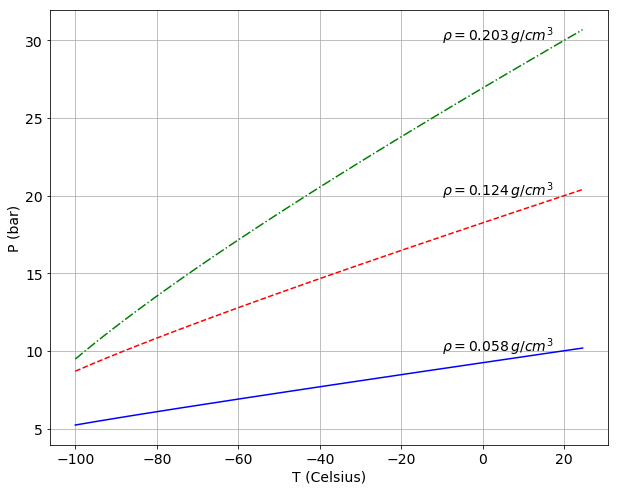

In [27]:
plt.plot(T,P10,'b')
plt.plot(T,P20,'r--')
plt.plot(T,P30,'g-.')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.text(-10, 30, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_3020/ (g/cm3)))
plt.text(-10, 20, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_2020/ (g/cm3)))
plt.text(-10, 10, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_1020/ (g/cm3)))
plt.show()

In [28]:
P30P = np.array([xe.P(t, rho_3020, perfect=True) for t in T]) / atmosphere

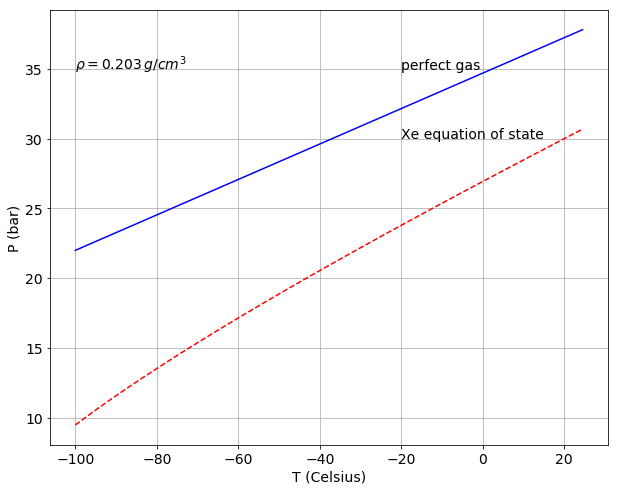

In [29]:
plt.plot(T,P30P,'b')
plt.plot(T,P30,'r--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.text(-100, 35, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_3020/ (g/cm3)))
plt.text(-20, 35, r'perfect gas')
plt.text(-20, 30, r'Xe equation of state')
#plt.text(-100, 35, r'https://www.nist.gov/sites/default/files/documents/srd/jpcrd470.pdf')
plt.show()

In [31]:
Tc = 198.15 #-75 C

### Second virial coefficient

In [14]:

# xenon
sigma = 0.3885 * nm
ek    = 274 * K # epsilon/k

Tc = 198.15 #-75 C
print('Tc/ek = {}'.format(Tc/ek))
Ls    = 0.06    # Lambda* 
Ls2   = Ls*Ls    # (Lambda*)^2 
Ls3   = Ls2*Ls    # (Lambda*)^3
Ls4   = Ls2*Ls2    # (Lambda*)^4
Ls6   = Ls4*Ls2    # (Lambda*)^4

uB = 1E-3 * meter3/kmol

Tc/ek = 0.7231751824817518


### Check that equation of State and 2nd Virial yield same result

In [37]:
T = np.arange(-100, 25, 0.5)
PF = np.array([xe.P(t, rho_2020, perfect=False) for t in T]) / atmosphere
PT = np.array([xe.P(t, rho_2020, perfect=True) for t in T]) / atmosphere
PF2 = np.array([xe.P2(t, rho_2020, perfect=False) for t in T]) / atmosphere
PT2 = np.array([xe.P2(t, rho_2020, perfect=True) for t in T]) / atmosphere

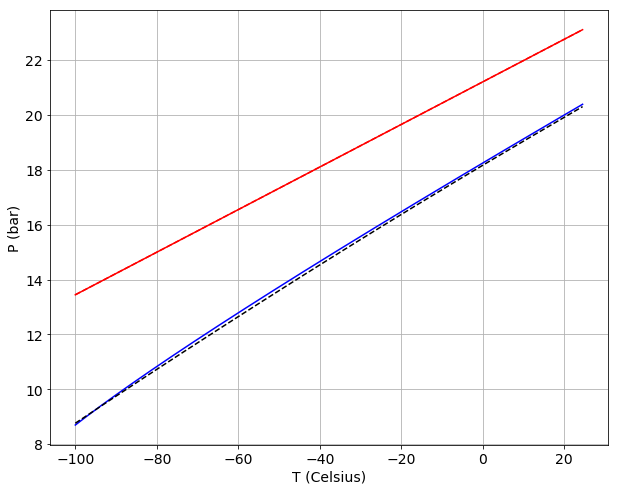

In [38]:
plt.plot(T,PF,'b')
plt.plot(T,PF2,'k--')
plt.plot(T,PT,'r')
plt.plot(T,PT2,'r--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.show()

### Xenon Helium mixtures

In [84]:
xehe = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=0.5, xXe=0.5)

In [85]:
print(xehe)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 380.8363165511463)   = 0.5 mol
            nHe  (XHe = 380.8363165511463)   = 0.5 mol
            PXe               = 8.138254123487801 atm
            PHe               = 8.138254123487801 atm
            P                 = 16.276508246975602 atm
            


In [86]:
xehe.pXe(tc=-90) /atmosphere

5.084500230997069

In [87]:
xehe.pHe(tc=-90) /atmosphere

5.084500230997069

In [88]:
xehe.p(tc=-90) /atmosphere

10.169000461994138

In [89]:
xehe.pBXe(tc=-90) /atmosphere

4.945958669606906

In [90]:
xehe.pBHe(tc=-90) /atmosphere

4.945958669606906

In [91]:
xehe.pB(tc=-90) /atmosphere

9.891917339213812

In [92]:
xe = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=0., xXe=1.0)
he = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=1., xXe=0.0)
xehe_8515 = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=0.15, xXe=0.85)

In [93]:
print(xe)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 761.6726331022926)   = 1.0 mol
            nHe  (XHe = 0.0)   = 0.0 mol
            PXe               = 16.276508246975602 atm
            PHe               = 0.0 atm
            P                 = 16.276508246975602 atm
            


In [94]:
print(he)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 0.0)   = 0.0 mol
            nHe  (XHe = 761.6726331022926)   = 1.0 mol
            PXe               = 0.0 atm
            PHe               = 16.276508246975602 atm
            P                 = 16.276508246975602 atm
            


In [95]:
print(xehe_8515)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 647.4217381369486)   = 0.85 mol
            nHe  (XHe = 114.25089496534389)   = 0.15 mol
            PXe               = 13.83503200992926 atm
            PHe               = 2.4414762370463405 atm
            P                 = 16.276508246975602 atm
            


In [96]:
15*0.15

2.25

In [97]:
xehe_8515.p(20) / atmosphere

16.276508246975602

In [98]:
xehe_8515.pB(20) / atmosphere

15.480065095512593

In [99]:
xehe_8515.p(-20) / atmosphere

14.05559632516416

In [100]:
xehe_8515.pB(-20) / atmosphere

13.148500132124799

In [101]:
T = np.arange(-100, 25, 0.5)
PF  = np.array([xe.pB(tc=t) / atmosphere for t in T])
PP  = np.array([xe.p(tc=t) / atmosphere for t in T])
PF2  = np.array([xehe_8515.pB(tc=t) / atmosphere for t in T])
PP2  = np.array([xehe_8515.p(tc=t) / atmosphere for t in T])

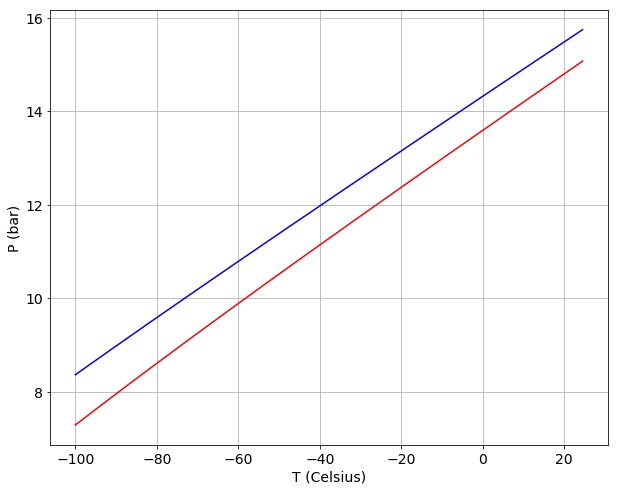

In [102]:
plt.plot(T,PF,'r')
#plt.plot(T,PP,'r--')
plt.plot(T,PF2,'b')
#plt.plot(T,PP2,'b--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
#plt.text(-40, 14,'Xe')
#plt.text(-25, 20,'He')
#plt.text(-40, 17,'0.15 * He + 0.85 * Xe')
plt.show()

In [ ]:
Image(filename='./Bolotnikov.png')